In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter

from scipy.stats import linregress
from scipy.stats.mstats import theilslopes

In [2]:
normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-ERA-20C/MARgrid_EUf.nc')
lon = ds.LON[jmin:jmax,imin:imax]
lat = ds.LAT[jmin:jmax,imin:imax]
H = np.array(ds.SH[jmin:jmax,imin:imax])

In [3]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False

In [4]:
alps_wp = np.repeat(alps[np.newaxis, :, :], 140, axis=0)
alps_wp.shape

(140, 91, 139)

In [85]:
alps_wp_season = np.repeat(alps_wp[:,np.newaxis, :, :], 4, axis=1)
alps_wp_season.shape

(140, 4, 91, 139)

In [5]:

yrly_tas_MPIhist_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_hist.npy')
yrly_tas_MPI245_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp245.npy')
yrly_tas_MPI585_globalmean = np.load('/bettik/castelli/data/MPI-ESM1-2-HR/yrly_tas_MPI_ssp585.npy')

In [6]:
yrly_tas_ECEarth_hist_globalmean = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_hist.npy')
yrly_tas_ECEarth_245_globalmean = np.load('/bettik/castelli/data/EC-Earth3/yrly_tas_ECEarth_ssp245.npy')

In [7]:
preindustrial_mean_MPI = yrly_tas_MPIhist_globalmean[:50].mean()
preindustrial_mean_MPI

13.91508167266446

In [8]:
preindustrial_mean_ECEarth = yrly_tas_ECEarth_hist_globalmean[:50].mean()
preindustrial_mean_ECEarth

13.771222926489624

In [22]:
# Reference period chosen as 1961-1990
refperiod_mean_MPI = yrly_tas_MPIhist_globalmean[111:140].mean()
print(refperiod_mean_MPI)
refperiod_mean_ECEarth = yrly_tas_ECEarth_hist_globalmean[111:140].mean()
print(refperiod_mean_ECEarth)


14.33313614127231
14.399734904063559


In [23]:
#yrly_warming_MPIhist = yrly_tas_MPIhist_globalmean[111:] - preindustrial_mean_MPI # hist is now 1961-2014
#yrly_warming_MPI245 = yrly_tas_MPI245_globalmean - preindustrial_mean_MPI
#yrly_warming_MPI585 = yrly_tas_MPI585_globalmean - preindustrial_mean_MPI

yrly_warming_MPIhist = yrly_tas_MPIhist_globalmean[111:] - refperiod_mean_MPI # hist is now 1961-2014
yrly_warming_MPI245 = yrly_tas_MPI245_globalmean - refperiod_mean_MPI
yrly_warming_MPI585 = yrly_tas_MPI585_globalmean - refperiod_mean_MPI

yrly_warming_MPIhist.shape

(54,)

In [24]:
yrly_warming_MPI245 = np.concatenate([yrly_warming_MPIhist,yrly_warming_MPI245])
yrly_warming_MPI585 = np.concatenate([yrly_warming_MPIhist,yrly_warming_MPI585])

In [25]:
#yrly_warming_ECEarth_hist = yrly_tas_ECEarth_hist_globalmean[111:] - preindustrial_mean_ECEarth # hist is now 1961-2014
#yrly_warming_ECEarth_245 = yrly_tas_ECEarth_245_globalmean - preindustrial_mean_ECEarth

yrly_warming_ECEarth_hist = yrly_tas_ECEarth_hist_globalmean[111:] - refperiod_mean_ECEarth # hist is now 1961-2014
yrly_warming_ECEarth_245 = yrly_tas_ECEarth_245_globalmean - refperiod_mean_ECEarth

yrly_warming_ECEarth = np.concatenate([yrly_warming_ECEarth_hist,yrly_warming_ECEarth_245])
yrly_warming_ECEarth.shape

(140,)

### MAR data

In [26]:
wp_meanseason_meanT = np.load('/bettik/castelli/data/saved_data_MAR_ECEarth3/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]

wp_meanseason_meanT.shape

(140, 4, 91, 139)

In [27]:
wp_meanseason_meanT_245 = np.load('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP245/wp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]

wp_meanseason_meanT_585 = np.copy(wp_meanseason_meanT_245)
fp_meanseason_meanT_585 = np.load('/bettik/castelli/data/saved_data_MAR_MPI_ESM1_2_HR/SSP585/fp_meanseason_meanT.npy')[:,:,jmin:jmax,imin:imax]
wp_meanseason_meanT_585[54:,:,:,:] = fp_meanseason_meanT_585

In [28]:
wp_meanyr_meanT = wp_meanseason_meanT.mean(axis=1)
wp_meanyr_meanT_245 = wp_meanseason_meanT_245.mean(axis=1)
wp_meanyr_meanT_585 = wp_meanseason_meanT_585.mean(axis=1)


wp_meanyr_meanT.shape

(140, 91, 139)

In [29]:
wp_meanyr_meanT_alps = np.ma.masked_array(wp_meanyr_meanT, mask=np.invert(alps_wp))
wp_meanyr_meanT_meanalps = wp_meanyr_meanT_alps.mean(axis=(1,2))

wp_meanyr_meanT_245_alps = np.ma.masked_array(wp_meanyr_meanT_245, mask=np.invert(alps_wp))
wp_meanyr_meanT_245_meanalps = wp_meanyr_meanT_245_alps.mean(axis=(1,2))

wp_meanyr_meanT_585_alps = np.ma.masked_array(wp_meanyr_meanT_585, mask=np.invert(alps_wp))
wp_meanyr_meanT_585_meanalps = wp_meanyr_meanT_585_alps.mean(axis=(1,2))

wp_meanyr_meanT_meanalps.shape


(140,)

In [33]:
# Reference period chosen as 1961-1990
refperiod_mean_MAR_MPI = wp_meanyr_meanT_245_meanalps[0:30].mean()
print(refperiod_mean_MAR_MPI)
refperiod_mean_MAR_ECEarth = wp_meanyr_meanT_meanalps[0:30].mean()
print(refperiod_mean_MAR_ECEarth)



6.0590877182712575
5.8922678132192114


In [34]:
wrming_20yrs_MAR_ECEarth = []
wrming_20yrs_ECEarth = []

for i in range(13):
    start = 10*i
    end = start+20
    wrming_20yrs_MAR_ECEarth.append(wp_meanyr_meanT_meanalps[start:end].mean() - refperiod_mean_MAR_ECEarth)
    wrming_20yrs_ECEarth.append(yrly_warming_ECEarth[start:end].mean())
wrming_20yrs_MAR_ECEarth

[-0.0024587715500938856,
 0.15224166561736663,
 0.0587373145969865,
 0.46592398547782743,
 0.8076597326411532,
 0.9059882858201753,
 1.1388915218367757,
 1.6740878250126405,
 2.114062104407493,
 2.4122353674428023,
 2.9632753130213665,
 3.2849791981227607,
 3.6297203810189753]

In [35]:
wrming_20yrs_MAR_MPI_245 = []
wrming_20yrs_MAR_MPI_585 = []
wrming_20yrs_MPI_245 = []
wrming_20yrs_MPI_585 = []


for i in range(13):
    start = 10*i
    end = start+20
    wrming_20yrs_MAR_MPI_245.append(wp_meanyr_meanT_245_meanalps[start:end].mean() - refperiod_mean_MAR_MPI)
    wrming_20yrs_MPI_245.append(yrly_warming_MPI245[start:end].mean())

    wrming_20yrs_MAR_MPI_585.append(wp_meanyr_meanT_585_meanalps[start:end].mean() - refperiod_mean_MAR_MPI)
    wrming_20yrs_MPI_585.append(yrly_warming_MPI585[start:end].mean())


In [77]:
MAR_wrming_20yrs = np.concatenate([wrming_20yrs_MAR_ECEarth,wrming_20yrs_MAR_MPI_245,wrming_20yrs_MAR_MPI_585[5:]])

GCM_wrming_20yrs = np.concatenate([wrming_20yrs_ECEarth,wrming_20yrs_MPI_245,wrming_20yrs_MPI_585[5:]])

res = theilslopes(MAR_wrming_20yrs, GCM_wrming_20yrs, 0.95)

linregress_wrming = linregress(GCM_wrming_20yrs, MAR_wrming_20yrs)

In [58]:
print(res[1])
print(res[0])

-0.2794467837535026
1.210175656810493


In [79]:
linregress_wrming.slope 

1.2271867933819611

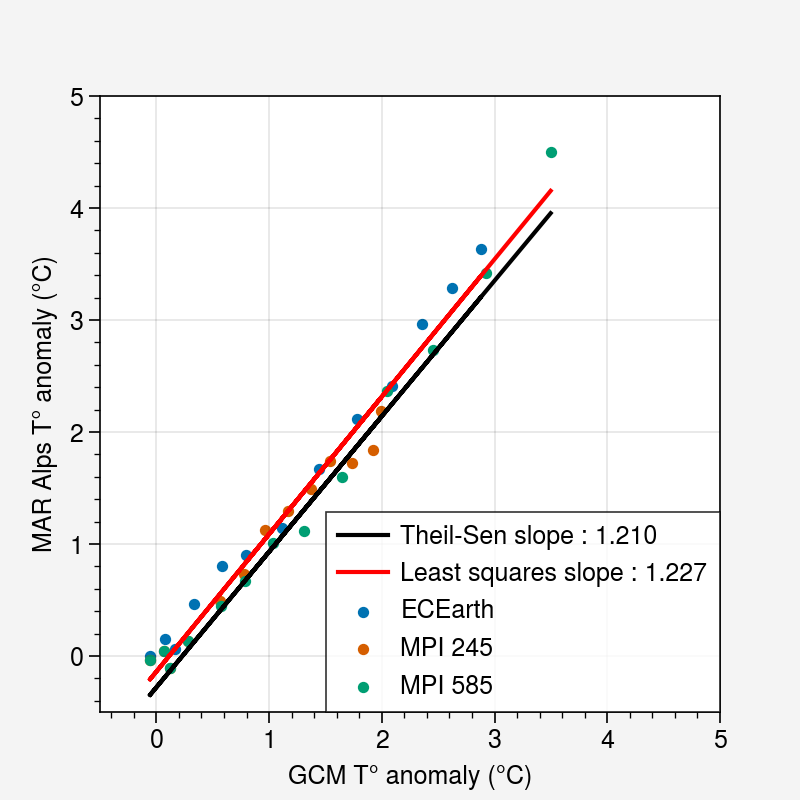

In [81]:


plt.scatter(wrming_20yrs_ECEarth,wrming_20yrs_MAR_ECEarth,label='ECEarth',s=12)
plt.scatter(wrming_20yrs_MPI_245,wrming_20yrs_MAR_MPI_245,label='MPI 245',s=12)
plt.scatter(wrming_20yrs_MPI_585,wrming_20yrs_MAR_MPI_585,label='MPI 585',s=12)

plt.plot(GCM_wrming_20yrs, res[1] + res[0] * GCM_wrming_20yrs, 'k-',label='Theil-Sen slope : 1.210')
#plt.plot(GCM_wrming_20yrs, res[1] + res[2] * GCM_wrming_20yrs, 'k:')
#plt.plot(GCM_wrming_20yrs, res[1] + res[3] * GCM_wrming_20yrs, 'k:')

plt.plot(GCM_wrming_20yrs,linregress_wrming.intercept + linregress_wrming.slope * GCM_wrming_20yrs,'r-',label='Least squares slope : 1.227')

plt.xlim([-0.5,5])
plt.ylim([-0.5,5])

plt.xlabel('GCM T° anomaly (°C)')
plt.ylabel('MAR Alps T° anomaly (°C)')

plt.legend()
#plt.title(

### Seasonal

In [87]:
wp_meanseason_meanT_alps = np.ma.masked_array(wp_meanseason_meanT, mask=np.invert(alps_wp_season))
wp_meanseason_meanT_meanalps = wp_meanseason_meanT_alps.mean(axis=(2,3))

wp_meanseason_meanT_245_alps = np.ma.masked_array(wp_meanseason_meanT_245, mask=np.invert(alps_wp_season))
wp_meanseason_meanT_245_meanalps = wp_meanseason_meanT_245_alps.mean(axis=(2,3))

wp_meanseason_meanT_585_alps = np.ma.masked_array(wp_meanseason_meanT_585, mask=np.invert(alps_wp_season))
wp_meanseason_meanT_585_meanalps = wp_meanseason_meanT_585_alps.mean(axis=(2,3))

wp_meanseason_meanT_meanalps.shape

(140, 4)

In [88]:
# Reference period chosen as 1961-1990
refperiod_mean_MAR_MPI_season = wp_meanseason_meanT_245_meanalps[0:30].mean(axis=0)
print(refperiod_mean_MAR_MPI_season)
refperiod_mean_MAR_ECEarth_season = wp_meanseason_meanT_meanalps[0:30].mean(axis=0)
print(refperiod_mean_MAR_ECEarth_season)


[-1.346462210617188 4.179696123673074 14.964117835353465 6.438999124675683]
[-1.8151249553973032 4.158427693223894 14.46050734519564 6.76526116985462]


In [102]:
wrming_20yrs_MAR_ECEarth_season = [[],[],[],[]]

wrming_20yrs_MAR_MPI_245_season = [[],[],[],[]]
wrming_20yrs_MAR_MPI_585_season = [[],[],[],[]]

for seas in range(4):
    
    for i in range(13):
        start = 10*i
        end = start+20
        wrming_20yrs_MAR_ECEarth_season[seas].append(wp_meanseason_meanT_meanalps[start:end,seas].mean() - refperiod_mean_MAR_ECEarth_season[seas])

        wrming_20yrs_MAR_MPI_245_season[seas].append(wp_meanseason_meanT_245_meanalps[start:end,seas].mean() - refperiod_mean_MAR_MPI_season[seas])

        wrming_20yrs_MAR_MPI_585_season[seas].append(wp_meanseason_meanT_585_meanalps[start:end,seas].mean() - refperiod_mean_MAR_MPI_season[seas])

wrming_20yrs_MAR_ECEarth_season_arr = np.array(wrming_20yrs_MAR_ECEarth_season)
wrming_20yrs_MAR_MPI_245_season_arr = np.array(wrming_20yrs_MAR_MPI_245_season)
wrming_20yrs_MAR_MPI_585_season_arr = np.array(wrming_20yrs_MAR_MPI_585_season)
wrming_20yrs_MAR_ECEarth_season_arr.shape

(4, 13)

In [110]:
MAR_wrming_20yrs_season = np.concatenate((wrming_20yrs_MAR_ECEarth_season_arr,wrming_20yrs_MAR_MPI_245_season_arr,wrming_20yrs_MAR_MPI_585_season_arr[:,5:]),axis=1)

res_season = []
linregress_wrming_season = []
for seas in range(4):
    res_season.append(theilslopes(MAR_wrming_20yrs_season[seas], GCM_wrming_20yrs, 0.95))

    linregress_wrming_season.append(linregress(GCM_wrming_20yrs, MAR_wrming_20yrs_season[seas]))

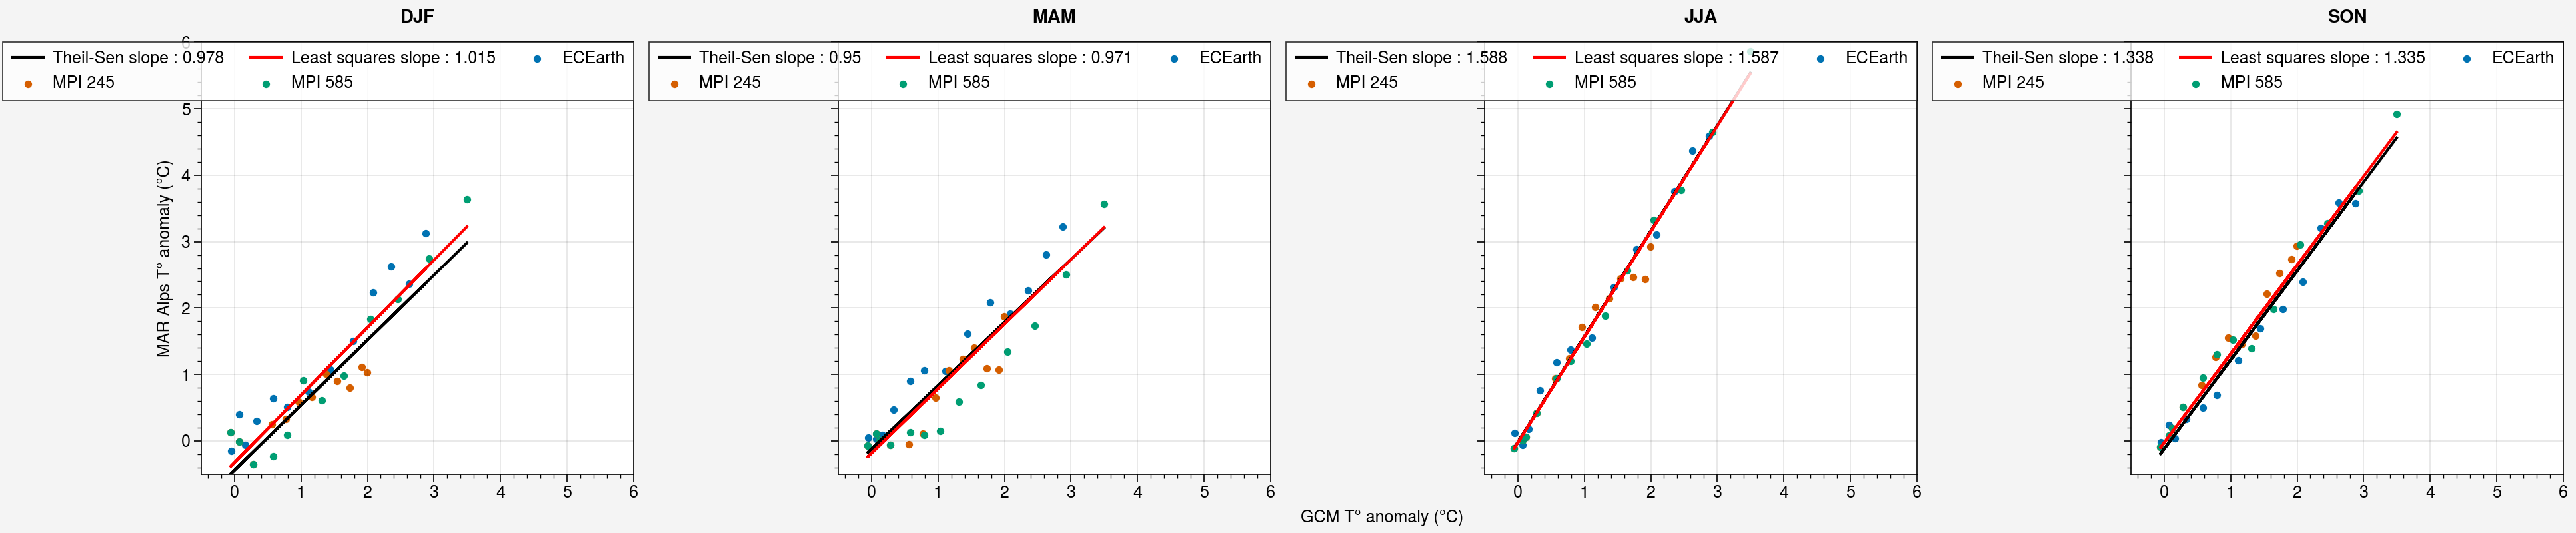

In [119]:
f,axs = pplt.subplots(ncols=4,figheight=4)

for seas in range(4):
    axs[seas].scatter(wrming_20yrs_ECEarth,wrming_20yrs_MAR_ECEarth_season[seas],label='ECEarth',s=12)
    axs[seas].scatter(wrming_20yrs_MPI_245,wrming_20yrs_MAR_MPI_245_season[seas],label='MPI 245',s=12)
    axs[seas].scatter(wrming_20yrs_MPI_585,wrming_20yrs_MAR_MPI_585_season[seas],label='MPI 585',s=12)

    axs[seas].plot(GCM_wrming_20yrs, res_season[seas][1] + res_season[seas][0] * GCM_wrming_20yrs, 'k-',label=f'Theil-Sen slope : {round(res_season[seas][0],3)}')
    #plt.plot(GCM_wrming_20yrs, res[1] + res[2] * GCM_wrming_20yrs, 'k:')
    #plt.plot(GCM_wrming_20yrs, res[1] + res[3] * GCM_wrming_20yrs, 'k:')
    
    axs[seas].plot(GCM_wrming_20yrs,linregress_wrming_season[seas].intercept + linregress_wrming_season[seas].slope * GCM_wrming_20yrs,'r-',
                   label=f'Least squares slope : {round(linregress_wrming_season[seas].slope,3)}')

    axs[seas].set_xlim([-0.5,6])
    axs[seas].set_ylim([-0.5,6])

    axs[seas].set_xlabel('GCM T° anomaly (°C)')
    axs[seas].set_ylabel('MAR Alps T° anomaly (°C)')

    axs[seas].legend()

axs.format(collabels = ['DJF','MAM','JJA','SON'])